# Filtragem de imagens e contornos com OpenCV

**Atenção**: Rode este notebook com `jupyter notebook` e não `jupyter lab`. A parte interativa requer que seja específico

Tópicos:
- [Equalização de histograma](#equalizacao)
- [Limiarização](#limiarizacao)
- [Filtragem linear](#filtragem)
- [Deteção de borda](#borda)
- [Detector de linhas de Canny](#canny)
- [Deteção de cores com inRange](#inrange)
- [Componentes conexos e contornos](#compconexos)
- [Transformada de Hough](#hough)
- [Operações morfológicas](#morfologia)

Bibliografia: 

[Cap.5 - Computer Vision. Shapiro](https://courses.cs.washington.edu/courses/cse576/book/ch5.pdf)

[Cap.3 - Digital Image Processing. Gonzales / Woods](http://web.ipac.caltech.edu/staff/fmasci/home/astro_refs/Digital_Image_Processing_2ndEd.pdf)

In [3]:
%matplotlib inline
import cv2
from matplotlib import pyplot as plt
import numpy as np
import time as t
import sys
import math
print ("OpenCV Version : %s " % cv2.__version__)

from ipywidgets import widgets, interact, interactive, FloatSlider, IntSlider

import auxiliar as aux

if (sys.version_info > (3, 0)): 
    # Modo Python 3
    import importlib
    importlib.reload(aux) # Para garantir que o Jupyter sempre relê seu trabalho
else:
    # Modo Python 2
    reload(aux)



OpenCV Version : 4.1.1 
Este script não deve ser executado diretamente
Este script não deve ser executado diretamente


<div id="equalizacao"></div>

# Equalização de histograma

Vamos rever equalização e definir limiarização

In [4]:
rintin = cv2.imread("RinTinTin.jpg", cv2.IMREAD_GRAYSCALE)

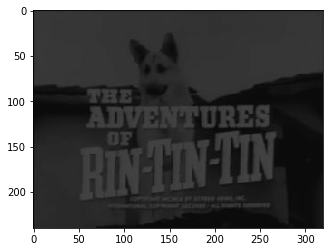

In [5]:
plt.imshow(rintin, cmap="Greys_r", vmin=0, vmax=255)

Pode-se, de forma prática, usar a função `cv2.equalizeHist` [para equalizar um histograma](https://docs.opencv.org/3.1.0/d5/daf/tutorial_py_histogram_equalization.html)

In [6]:
rintin_eq = cv2.equalizeHist(rintin)

Verifiquemos o resultado

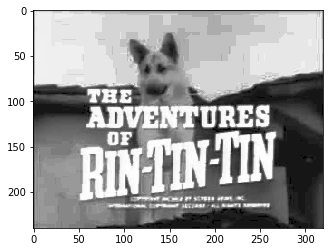

In [7]:
plt.imshow(rintin_eq, cmap="Greys_r", vmin=0, vmax=255)

<div id="limiarizacao"></div>

## Limiarização

Para a limiarização, converte-se uma imagem em tons de cinza para uma imagem binária. A função `cv2.threshold` [é capaz de fazê-lo](https://docs.opencv.org/3.4/d7/d4d/tutorial_py_thresholding.html)

In [8]:
ret,limiarizada = cv2.threshold(rintin_eq,0,255,cv2.THRESH_OTSU)


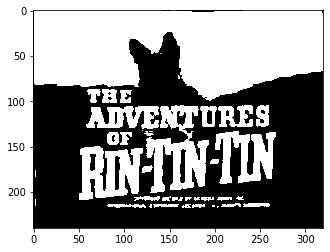

In [9]:
plt.imshow(limiarizada, cmap="Greys_r")

<div id="filtragem"></div>

# Filtragem linear

Na filtragem linear, uma pequena matriz chamada de `kernel` é convoluída com a imagem. *Veja na lousa a explicação do professor*

In [10]:
img = cv2.imread("hall_box_battery1.jpg",cv2.IMREAD_GRAYSCALE )

In [11]:
small = cv2.resize(img, (768, 384), 0,0)

In [12]:
plt.rcParams["figure.figsize"] = (10,5)


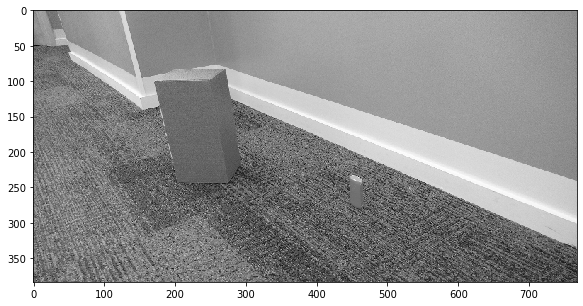

In [13]:
plt.imshow(small, cmap="Greys_r")

In [14]:
from ipywidgets import interact, FloatSlider

In [15]:
blur = small
    
def plot_blur(sz):
    global blur
    plt.rcParams["figure.figsize"] = (10,5)
    blur = cv2.blur(small, (sz,sz))
    plt.imshow(blur, cmap="Greys_r")
    

<function __main__.plot_blur>

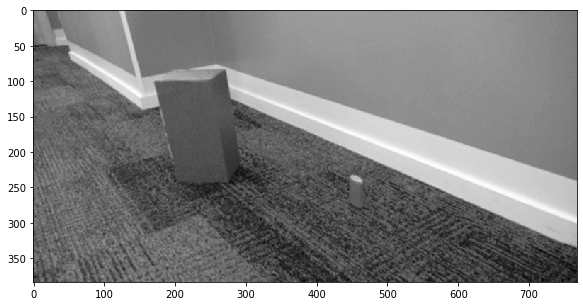

In [16]:
interact(plot_blur, sz=IntSlider(min=1, max=15, step=1, value=3))

<div id="borda"></div>

## Deteção de borda subsequente

In [17]:
out3 = small

def plot_filter(widgets, data):
    kernel = aux.make_np_from_widgets_list(widgets)
    global out3
    out3 = cv2.filter2D(data, -1,  kernel)
    plt.imshow(out3, cmap="Greys_r")
    
    

In [18]:
list_kernel, widgets_kernel = aux.make_widgets_mat(3,3)

In [19]:
widgets_kernel

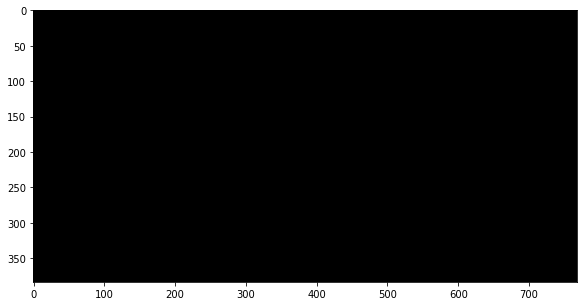

In [20]:
plot_filter(list_kernel, blur)

Veja mais alguns kernels de processamento de imagem [no link](http://setosa.io/ev/image-kernels/)

# Realce de bordas

$$
\begin{pmatrix} -1 & -1 & -1 \\
-1 & 9 & -1 \\
-1 & -1 & -1 
\end{pmatrix}
$$

# Filtro de Sobel

$$
\begin{pmatrix} -1 & 0 & +1 \\
-2 & 0 & +2 \\
-1 & 0 & +1 
\end{pmatrix}
$$

<div id="canny"></div>

# Detector de linhas de Canny

O detector de linhas de *Canny* combina algumas operações lineares de forma mais sofisticada

In [21]:
min_contrast = 100
max_contrast = 200
linhas = cv2.Canny(small, min_contrast, max_contrast )

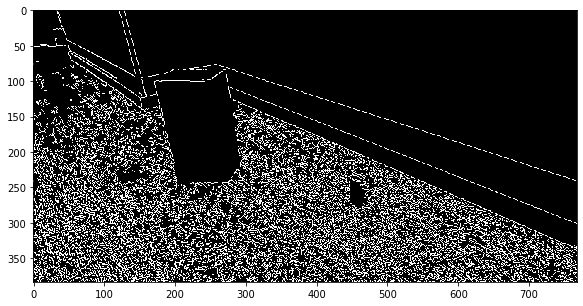

In [22]:
plt.imshow(linhas, cmap="Greys_r")

In [23]:
canny_img = None

def canny(minimo, maximo):
    img = cv2.Canny(small, minimo, maximo)
    plt.imshow(img, cmap="Greys_r")
    global canny_img
    canny_img = img

In [24]:
w = interactive(canny, minimo=10, maximo=40)

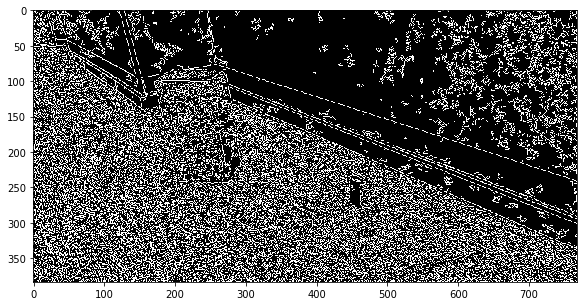

In [25]:
w

<div id="inrange"></div>

# Deteção de cores com inRange

In [26]:
img_color = cv2.imread("hall_box_battery1.jpg")
img_rgb = cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB)
img_hsv = cv2.cvtColor(img_color, cv2.COLOR_BGR2HSV)

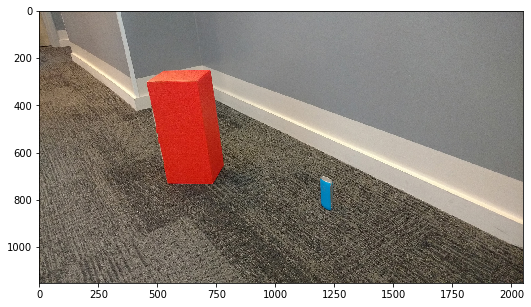

In [27]:
plt.imshow(img_rgb)

In [28]:
colorpicker = widgets.ColorPicker(
    concise=False,
    description='Escolha uma cor',
    value='#ff00ff',
    disabled=False
)

In [29]:
colorpicker

In [34]:
hsv1, hsv2 = aux.ranges(colorpicker.value)

In [35]:
hsv1

array([108,  50,  50], dtype=uint8)

In [33]:
hsv2

array([121, 255, 255], dtype=uint8)

In [109]:
mask = cv2.inRange(img_hsv, hsv1, hsv2)    

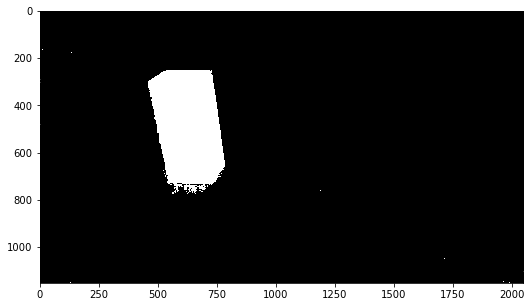

In [110]:
plt.imshow(mask, cmap="Greys_r")

In [86]:
selecao = cv2.bitwise_and(img_rgb, img_rgb, mask=mask)

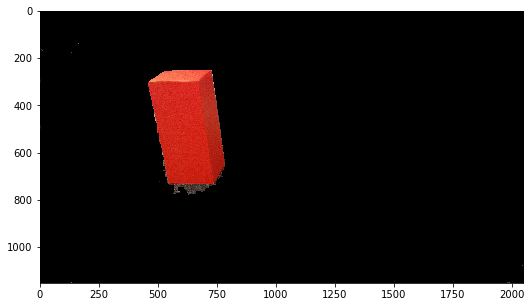

In [87]:
# Fechamos todos os buracos menores que um quadrado 10x10
segmentado_cor = cv2.morphologyEx(mask,cv2.MORPH_CLOSE,np.ones((10, 10)))
selecao = cv2.bitwise_and(img_rgb, img_rgb, mask=segmentado_cor)
plt.imshow(selecao)


<div id="compconexos"></div>

## Componentes conexos e contornos

E se tivéssemos mais de um objeto vermelho na imagem? Como faríamos para identificá-los?

Fonte das imagens: [http://time.com/4299724/coca-cola-diet-coke-redesign/](http://time.com/4299724/coca-cola-diet-coke-redesign/)

In [89]:
coke = cv2.imread("coke-cans.jpg")
coke_rgb= cv2.cvtColor(coke, cv2.COLOR_BGR2RGB)
coke_hsv= cv2.cvtColor(coke, cv2.COLOR_BGR2HSV)

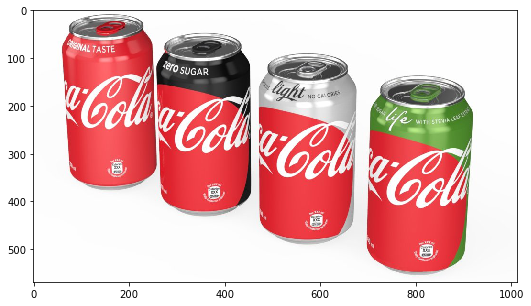

In [91]:
plt.imshow(coke_rgb)

In [94]:
cor_menor = np.array([172, 50, 50])
cor_maior = np.array([180, 255, 255])
mask_coke = cv2.inRange(coke_hsv, cor_menor, cor_maior)


In [95]:

segmentado_coke = cv2.morphologyEx(mask_coke,cv2.MORPH_CLOSE,np.ones((4, 4)))


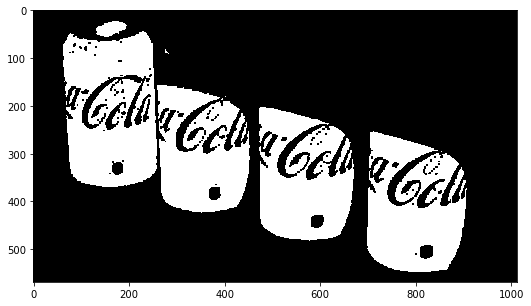

In [97]:
plt.imshow(segmentado_coke, cmap="Greys_r", vmin=0, vmax=255)


Contorno - juntando componentes conexos

In [40]:
# Para OpenCV cv2 versão 3 use a linha abaixo:
#img_out, contornos, arvore = cv2.findContours(segmentado_coke.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) 

contornos, arvore = cv2.findContours(segmentado_coke.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) 

In [41]:
contornos_img = coke_rgb.copy()
cv2.drawContours(contornos_img, contornos, -1, [0, 0, 255], 3);
    

In [42]:
len(contornos)

115

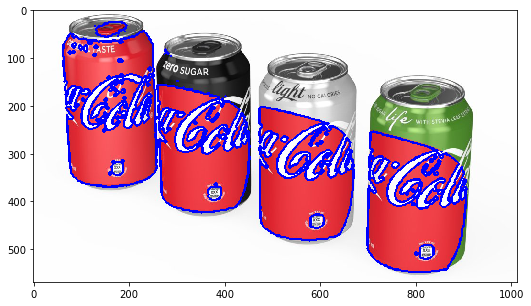

In [43]:
plt.imshow(contornos_img)

In [44]:
maior = None
maior_area = 0
for c in contornos:
    area = cv2.contourArea(c)
    if area > maior_area:
        maior_area = area
        maior = c



In [45]:
cv2.drawContours(contornos_img, [maior], -1, [0, 255, 255], 5);


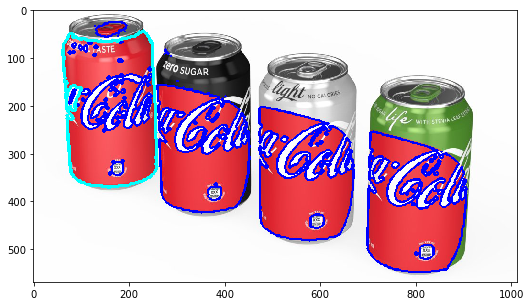

In [46]:
plt.imshow(contornos_img)

<div id="hough"></div>

# Transformada de Hough

A [transformada de Hough](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_houghlines/py_houghlines.html) encontra todas as possíveis linhas que estão presentes na imagem

In [47]:
hough_img = canny_img.copy() # Vamos reusar a imagem de canny


lines = cv2.HoughLinesP(hough_img, 10, math.pi/180.0, 100, np.array([]), 45, 5)

a,b,c = lines.shape

hough_img_rgb = cv2.cvtColor(hough_img, cv2.COLOR_GRAY2BGR)

for i in range(a):
    # Faz uma linha ligando o ponto inicial ao ponto final, com a cor vermelha (BGR)
    cv2.line(hough_img_rgb, (lines[i][0][0], lines[i][0][1]), (lines[i][0][2], lines[i][0][3]), (0, 0, 255), 5, cv2.LINE_AA)

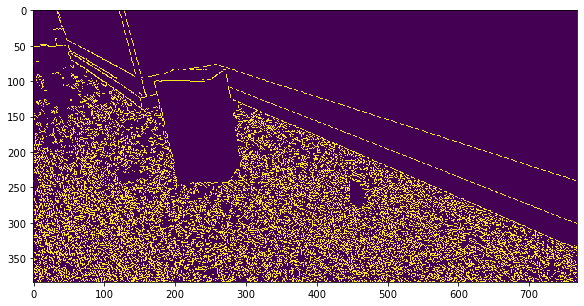

In [48]:
plt.imshow(linhas)

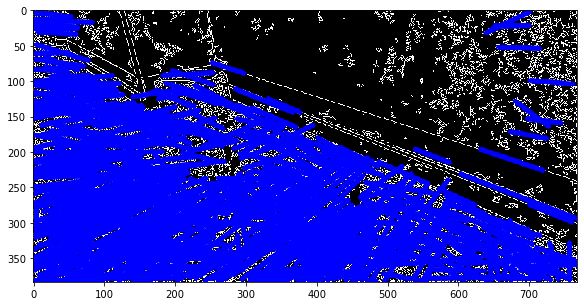

In [49]:
plt.imshow(hough_img_rgb)

# Hough Circles

Funciona de forma equivalente, mas acha círculos. Veja o demo `draw_circles_video.py`


<div id="morfologia"></div>

# Operações morfológicas

Veja em [https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html) e nos slides